In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [56]:
def create_UE_cluster(x1, y1, x2, y2):
  X = []
  Y = []
  Z = []
  while(len(X)<10):
    cord_x = round(random.uniform(x1,x2),2)
    if(cord_x not in X):
      X.append(cord_x)
  while(len(Y)<10):
    cord_y = round(random.uniform(y1,y2),2)
    if(cord_y not in Y):
      Y.append(cord_y)
  while(len(Z)<10):
      Z.append(0)
  k = []
  i = 0
  while(i<10):
      k.append([X[i],Y[i],Z[i]])
      i += 1

  return k

ue_cluster_1 = create_UE_cluster(400, 450, 470, 520)
ue_cluster_2 = create_UE_cluster(30,30,100,100)


In [57]:

class UAVTASKENV():
  def __init__(self, c1, c2):
    self.k = plt.subplots()
    self.fig = self.k[0]
    self.ax = self.k[1]
    self.cluster1 = c1
    self.cluster2 = c2
    self.uecord = self.cluster1+self.cluster2
    self.fog = [[450,450,100],[50,50,100]]
    self.ue_data = self.UE_data()
    self.connected_array = np.full(20,-1)
    self.ca = np.full(10,0)
    self.ca1 = np.full(10,1)
    self.checkpoint =  np.concatenate((self.ca, self.ca1))

    self.P = 5

  def dist(self, pos1, pos2):
    distance = ((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2+(pos1[2]-pos2[2])**2)**0.5
    return distance

  def connected(self, pos_ue, pos_uav, i, j):
    if(self.dist(pos_ue, pos_uav)<=300):
      if(self.connected_array[j]==-1):
        self.connected_array[j] = i

  def channelGain(self, d):
    return -50 - 20*(math.log10(d))

  def SNR(self, gain, Transmitpower):
    P = Transmitpower*10**(gain/10)
    N = 10**(-13)
    return P/N

  def datarate(self, SNR):
    return math.log2(1+SNR)


  def step(self, actions):
    for i, state in enumerate(self.state):
      action = actions[i]
      d = (action[0])*270
      theta = (action[1])*180
      dummy = []
      dummy.append(state[0])
      dummy.append(state[1])
      dummy = np.array(dummy, dtype = np.float32)
      state[0] += d*math.cos(math.radians(theta))
      state[1] += d*math.sin(math.radians(theta))
      if((state[0]>600 or state[0]<0 )or (state[1]>600 or state[1]<0)):
        state[0] = dummy[0]
        state[1] = dummy[1]
      for j in range(0,len(self.uecord)):
        self.connected(self.uecord[j], state, i, j)

    U = 0
    for i, state in enumerate(self.state):
      action = actions[i]
      X = []
      T = 0
      E = 0
      th = 100000000
      for j in range(2,22):
        X.append(action[j]/2 + 0.5)

      for j in range(0,20):
        uav = state
        ue = self.uecord[j]
        dis = self.dist(ue, uav)
        C = self.ue_data[j][0]
        D = self.ue_data[j][1]
        r1 = self.datarate(self.SNR(self.channelGain(dis), 0.1))
        t1 = D/r1
        e1 = 0.1*t1
        x = X[j]
        t2 = (0.001*(x*C*D))/3
        e2 = 0.3*t2
        if(x==1):
          th = min(th, r1)

        dis2 = self.dist(uav, self.fog[i])
        r2 = self.datarate(self.SNR(self.channelGain(dis2), 5))
        t3 = (1-x)*D/r2
        e3 = 5*t3
        t4 = 0.0001*((1-x)*C*D)

        if(x!=1):
          th = min(th, min(r1,r2))


        factor = 10

        if(self.connected_array[j]==i):
          factor = 1

        t_X = t1+t2+t3+t4
        e_X = e1+e2+e3

        T += factor*t_X
        E += factor*e_X

      #minimise the system cost so U = sum of energy and time and reciprocal of throughput as we have to maximise thorughput
      U += ((E+T)+(1/th))
    ct = 0
    for x in self.connected_array:
      if(x==-1):
        ct += 1

    #U = U*ct
    #2 ways to calculate coverage
    #either by multiplying the count of disconnected UAVs in reward itsef, or by giving penalty
    #like
    if(ct>6):
      U += 10*ct
    return self.state, -1*U, False, {}



  def UE_data(self):
    C = []
    D = []
    L = []
    while(len(C)<20):
      C.append(random.randint(100,200))
    while(len(D)<20):
      D.append(random.randint(1,5))
    while(len(L)<20):
      L.append(1)
    k = []
    i = 0
    while(i<20):
      k.append([C[i],D[i],L[i]])
      i += 1
    self.statex = np.array(k, dtype = np.float32)
    return self.statex

  def reset(self):
    self.connected_array = np.full(20,-1)
    self.ue_data = self.UE_data()
    X = round(random.uniform(270,300),2)
    Y = round(random.uniform(295,300),2)
    X1 = round(random.uniform(270,300),2)
    Y1 = round(random.uniform(295,300),2)
    if(X1==X):
      while(X1==X and X1-X<=20):
        X1 = round(random.uniform(300,400),2)

    if(Y1==Y):
      while(Y1==Y):
        Y1 = round(random.uniform(300,400),2)

    u1 = np.array([X,Y,60], dtype = np.float32)
    u2 = np.array([X1,Y1,60], dtype = np.float32)
    self.state = [u1,u2]
    return self.state

  def render(self):
    self.ax.cla()
    X = []
    Y = []
    for i in range(0,10):
        X.append(self.cluster1[i][0])
        Y.append(self.cluster1[i][1])

    for i in range(0,10):
        X.append(self.cluster2[i][0])
        Y.append(self.cluster2[i][1])
    self.ax.set_xlim([0,600])
    self.ax.set_ylim([0,600])
    self.ax.set_title('UE-Clusters')
    self.ax.plot(np.array(X),np.array(Y),'ro')
    uavcord1 = (self.state[0][0],self.state[0][1])
    uavcord2 = (self.state[1][0],self.state[1][1])
    self.ax.scatter(uavcord1[0], uavcord1[1], marker = "X", s= 100)
    self.ax.scatter(uavcord2[0], uavcord2[1], marker = "X", s= 100)
    self.ax.scatter(self.fog[0][0], self.fog[0][1], marker = "^", s= 100)
    self.ax.scatter(self.fog[1][0], self.fog[1][1], marker = "^", s= 100)
    self.ax.grid(True)
    plt.show()
    plt.pause(0.8)


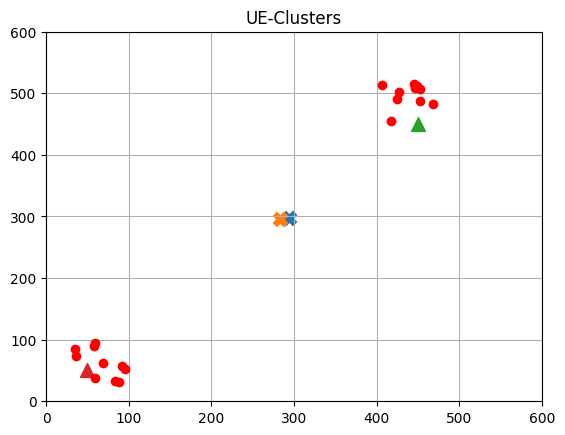

In [58]:
a = UAVTASKENV(ue_cluster_1, ue_cluster_2)
a.reset()
a.render()

In [59]:
class Buffer:
    def __init__(self, max_size, critic_dims, actor_dims,
            n_actions, n_agents, batch_size):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.n_agents = n_agents
        self.actor_dims = actor_dims
        self.batch_size = batch_size
        self.n_actions = n_actions

        self.state_memory = np.zeros((self.mem_size, critic_dims))
        self.new_state_memory = np.zeros((self.mem_size, critic_dims))
        self.reward_memory = np.zeros((self.mem_size, n_agents))

        self.init_actor_memory()

    def init_actor_memory(self):
        self.actor_state_memory = []
        self.actor_new_state_memory = []
        self.actor_action_memory = []

        for i in range(self.n_agents):
            self.actor_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_new_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_action_memory.append(
                            np.zeros((self.mem_size, self.n_actions)))


    def store_transition(self, raw_obs, state, action, reward,
                               raw_obs_, state_, done):


        index = self.mem_cntr % self.mem_size

        for agent_idx in range(self.n_agents):
            self.actor_state_memory[agent_idx][index] = raw_obs[agent_idx]
            self.actor_new_state_memory[agent_idx][index] = raw_obs_[agent_idx]
            self.actor_action_memory[agent_idx][index] = action[agent_idx]

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.mem_cntr += 1

    def sample_buffer(self):
        if(self.ready()!=True):
          return

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        states = self.state_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]

        actor_states = []
        actor_new_states = []
        actions = []
        for agent_idx in range(self.n_agents):
            actor_states.append(self.actor_state_memory[agent_idx][batch])
            actor_new_states.append(self.actor_new_state_memory[agent_idx][batch])
            actions.append(self.actor_action_memory[agent_idx][batch])

        return actor_states, states, actions, rewards, \
               actor_new_states, states_

    def ready(self):
        if self.mem_cntr >= self.batch_size:
            return True

In [60]:
import os
print(os.path)

<module 'posixpath' from '/usr/lib/python3.10/posixpath.py'>


In [61]:
import tensorflow as tf

class CriticNetwork(tf.keras.Model):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_agents, n_actions, name, chkpt_dir):
        super(CriticNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = tf.keras.layers.Dense(fc1_dims, activation='relu')
        self.fc2 = tf.keras.layers.Dense(fc2_dims, activation='relu')
        self.q = tf.keras.layers.Dense(1)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=beta)


    def call(self, state, action):
        x = tf.concat([state, action], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.q(x)

        return q

    def save_checkpoint(self):
        self.save_weights(self.chkpt_file)

    def load_checkpoint(self):
        self.load_weights(self.chkpt_file)


class ActorNetwork(tf.keras.Model):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name, chkpt_dir):
        super(ActorNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = tf.keras.layers.Dense(fc1_dims, activation='relu')
        self.fc2 = tf.keras.layers.Dense(fc2_dims, activation='relu')
        self.pi = tf.keras.layers.Dense(n_actions, activation='tanh')

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        pi = self.pi(x)

        return pi

    def save_checkpoint(self):
        self.save_weights(self.chkpt_file)

    def load_checkpoint(self):
        self.load_weights(self.chkpt_file)


In [62]:
class Agent:
    def __init__(self, actor_dims, critic_dims, n_actions, n_agents, agent_idx, chkpt_dir,
                 alpha=0.01, beta=0.01, fc1=300, fc2=400, gamma=0.99, tau=0.005):
        self.gamma = gamma
        self.tau = tau
        self.n_actions = n_actions
        self.agent_name = 'agent_%s' % agent_idx
        self.actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions,
                                  chkpt_dir=chkpt_dir, name=self.agent_name + '_actor')
        self.critic = CriticNetwork(beta, critic_dims, fc1, fc2, n_agents, n_actions,
                                    chkpt_dir=chkpt_dir, name=self.agent_name + '_critic')
        self.target_actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions,
                                         chkpt_dir=chkpt_dir, name=self.agent_name + '_target_actor')
        self.target_critic = CriticNetwork(beta, critic_dims, fc1, fc2, n_agents, n_actions,
                                           chkpt_dir=chkpt_dir, name=self.agent_name + '_target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        noise = tf.random.normal(shape=(self.n_actions,))
        action = actions + noise

        return action.numpy()[0]

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        for target_weights, weights in zip(self.target_actor.weights, self.actor.weights):
            target_weights.assign(tau * weights + (1 - tau) * target_weights)

        for target_weights, weights in zip(self.target_critic.weights, self.critic.weights):
            target_weights.assign(tau * weights + (1 - tau) * target_weights)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()


In [63]:
import tensorflow as tf
import tensorflow.keras.losses as kloss


class MADDPG:
    def __init__(self, actor_dims, critic_dims, n_agents, n_actions,
                 scenario='simple', alpha=0.01, beta=0.01, fc1=64,
                 fc2=64, gamma=0.99, tau=0.005, chkpt_dir='tmp/maddpg/'):
        self.agents = []
        self.n_agents = n_agents
        self.n_actions = n_actions
        chkpt_dir += scenario
        for agent_idx in range(self.n_agents):
            self.agents.append(Agent(actor_dims[agent_idx], critic_dims,
                                     n_actions, n_agents, agent_idx, alpha=alpha, beta=beta,
                                     chkpt_dir=chkpt_dir))

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        for agent in self.agents:
            agent.save_models()

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        for agent in self.agents:
            agent.load_models()

    def choose_action(self, raw_obs):
        actions = []
        for agent_idx, agent in enumerate(self.agents):
            action = agent.choose_action(raw_obs[agent_idx])
            actions.append(action)
        return actions

    def learn(self, memory):
        if not memory.ready():
            return

        actor_states, states, actions, rewards, \
        actor_new_states, states_ = memory.sample_buffer()


        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        states_ = tf.convert_to_tensor(states_, dtype=tf.float32)


        all_agents_new_actions = []
        old_agents_actions = []

        for agent_idx, agent in enumerate(self.agents):
            new_states = tf.convert_to_tensor(actor_new_states[agent_idx], dtype=tf.float32)

            new_pi = agent.target_actor(new_states)

            all_agents_new_actions.append(new_pi)

            old_agents_actions.append(actions[agent_idx])


        new_actions = tf.concat(all_agents_new_actions, axis=1)
        old_actions = tf.concat(old_agents_actions, axis=1)

        for agent_idx, agent in enumerate(self.agents):


          with tf.GradientTape() as tape:
            critic_value_ = agent.target_critic(states_, new_actions)
            critic_value_ = tf.reshape(critic_value_, (-1,))
            critic_value = agent.critic(states, old_actions)
            critic_value = tf.reshape(critic_value, (-1,))

            target = rewards[:, agent_idx] + agent.gamma * critic_value_
            critic_loss = tf.keras.losses.mean_squared_error(target, critic_value)


            critic_grads = tape.gradient(critic_loss, agent.critic.trainable_variables)
            agent.critic.optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        with tf.GradientTape() as tape:
            all_agents_new_mu_actions = []
            for agent_idx in range(2):
              mu_states = tf.convert_to_tensor(actor_states[agent_idx], dtype=tf.float32)
              pi = agent.actor(mu_states)
              all_agents_new_mu_actions.append(pi)
            mu = tf.concat(all_agents_new_mu_actions, axis=1)
            actor_loss = agent.critic(states, mu)
            actor_loss = -tf.reduce_mean(actor_loss)
            actor_grads = tape.gradient(actor_loss, agent.actor.trainable_variables)
            agent.actor.optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        agent.update_network_parameters()


... saving checkpoint ...
... saving checkpoint ...
episode 1 average score -62949.9
... saving checkpoint ...
episode 2 average score -61976.0
... saving checkpoint ...
episode 3 average score -61409.1
... saving checkpoint ...
episode 4 average score -59930.3
episode 5 average score -62457.0
episode 6 average score -61163.7
episode 7 average score -62338.0
episode 8 average score -61001.7
episode 9 average score -60413.4
... saving checkpoint ...
episode 10 average score -59565.3
... saving checkpoint ...
episode 11 average score -58715.1
... saving checkpoint ...
episode 12 average score -58043.1
episode 13 average score -58259.3
episode 14 average score -58171.1
... saving checkpoint ...
episode 15 average score -58042.4
... saving checkpoint ...
episode 16 average score -57526.1
... saving checkpoint ...
episode 17 average score -57108.0
... saving checkpoint ...
episode 18 average score -56919.5
... saving checkpoint ...
episode 19 average score -56850.8
... saving checkpoint ...

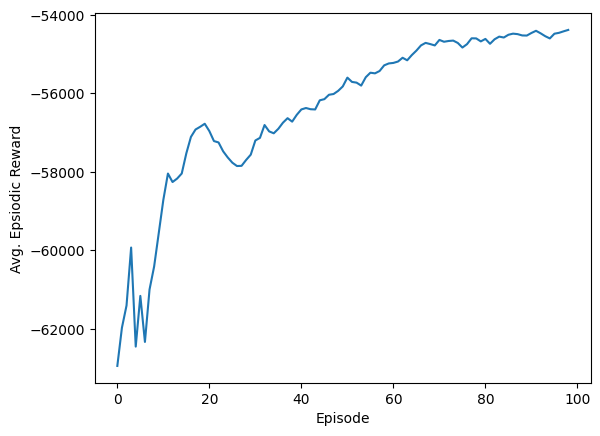

In [66]:
def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

if __name__ == '__main__':


    env = UAVTASKENV(ue_cluster_1, ue_cluster_2)
    n_agents = 2
    actor_dims = []
    for i in range(n_agents):
        actor_dims.append(3)
    critic_dims = sum(actor_dims)
    PRINT_INTERVAL = 1


    n_actions = 22
    maddpg_agents = MADDPG(actor_dims, critic_dims, n_agents, n_actions,
                           fc1=300, fc2=400,
                           alpha=0.001, beta=0.001,
                           chkpt_dir='tmp/maddpg/')

    memory = Buffer(1000000, critic_dims, actor_dims,
                        n_actions, n_agents, batch_size=100)



    total_steps = 0
    score_history = []
    n_episodes = 100
    timestamp = 200
    avg = []
    bestscore = -10000000



    for i in range(n_episodes):
        obs = env.reset()
        score = 0
        episode_step = 0

        for j in range(timestamp):

            actions = maddpg_agents.choose_action(obs)
            obs_, reward, done, info = env.step(actions)

            state = obs_list_to_state_vector(obs)
            state_ = obs_list_to_state_vector(obs_)



            memory.store_transition(obs, state, actions, reward, obs_, state_, done)

            if total_steps % 10 == 0:
                maddpg_agents.learn(memory)

            obs = obs_

            score += reward
            total_steps += 1
            episode_step += 1

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        if bestscore<avg_score:
          maddpg_agents.save_checkpoint()
          bestscore = avg_score
        if i % PRINT_INTERVAL == 0 and i > 0:
            print('episode', i, 'average score {:.1f}'.format(avg_score))
            avg.append(avg_score)


    plt.plot(avg)
    plt.xlabel("Episode")
    plt.ylabel("Avg. Epsiodic Reward")
    plt.show()